In [1]:
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2024/05/27 21:52:43 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/MLOps_zoomcamp/02-Experiment-tracking/mlruns/2', creation_time=1716846763721, experiment_id='2', last_update_time=1716846763721, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.060351536580523

/tmp/ipykernel_24487/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_24487/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


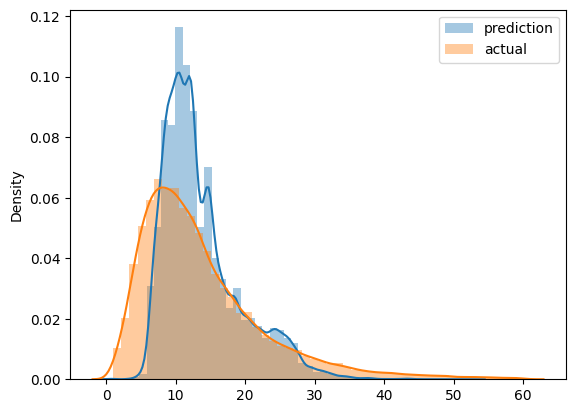

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet')
len(df_train), len(df_val)

(65946, 62574)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [9]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.037803764245777

In [10]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [11]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "olawale")
    
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [13]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [14]:
def objective(params):
    
    with mlflow.start_run():
        
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [15]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3), exp(0) - [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:52:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.76386                           
[1]	validation-rmse:8.27752                           
[2]	validation-rmse:7.85094                           
[3]	validation-rmse:7.47838                           
[4]	validation-rmse:7.15811                           
[5]	validation-rmse:6.87499                           
[6]	validation-rmse:6.64111                           
[7]	validation-rmse:6.43008                           
[8]	validation-rmse:6.26393                           
[9]	validation-rmse:6.11165                           
[10]	validation-rmse:5.97978                          
[11]	validation-rmse:5.87724                          
[12]	validation-rmse:5.78232                          
[13]	validation-rmse:5.70994                          
[14]	validation-rmse:5.64695                          
[15]	validation-rmse:5.59848                          
[16]	validation-rmse:5.54587                          
[17]	validation-rmse:5.50868                          
[18]	valid

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:54:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.66114                                                       
[1]	validation-rmse:6.65210                                                       
[2]	validation-rmse:6.06342                                                       
[3]	validation-rmse:5.72691                                                       
[4]	validation-rmse:5.53471                                                       
[5]	validation-rmse:5.43077                                                       
[6]	validation-rmse:5.38126                                                       
[7]	validation-rmse:5.34589                                                       
[8]	validation-rmse:5.32789                                                       
[9]	validation-rmse:5.30703                                                       
[10]	validation-rmse:5.29798                                                      
[11]	validation-rmse:5.29177                                                      
[12]

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:55:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.09743                                                    
[1]	validation-rmse:7.21089                                                    
[2]	validation-rmse:6.58383                                                    
[3]	validation-rmse:6.14942                                                    
[4]	validation-rmse:5.85432                                                    
[5]	validation-rmse:5.65349                                                    
[6]	validation-rmse:5.52010                                                    
[7]	validation-rmse:5.42777                                                    
[8]	validation-rmse:5.36467                                                    
[9]	validation-rmse:5.31866                                                    
[10]	validation-rmse:5.28805                                                   
[11]	validation-rmse:5.26726                                                   
[12]	validation-rmse:5.25253            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:56:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.10488                                                    
[1]	validation-rmse:6.09776                                                    
[2]	validation-rmse:5.67346                                                    
[3]	validation-rmse:5.49552                                                    
[4]	validation-rmse:5.41335                                                    
[5]	validation-rmse:5.36546                                                    
[6]	validation-rmse:5.34080                                                    
[7]	validation-rmse:5.32557                                                    
[8]	validation-rmse:5.31434                                                    
[9]	validation-rmse:5.30807                                                    
[10]	validation-rmse:5.30273                                                   
[11]	validation-rmse:5.29221                                                   
[12]	validation-rmse:5.28987            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:57:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.42065                                                    
[1]	validation-rmse:7.70552                                                    
[2]	validation-rmse:7.14203                                                    
[3]	validation-rmse:6.70214                                                    
[4]	validation-rmse:6.36425                                                    
[5]	validation-rmse:6.10524                                                    
[6]	validation-rmse:5.89372                                                    
[7]	validation-rmse:5.75017                                                    
[8]	validation-rmse:5.63582                                                    
[9]	validation-rmse:5.54866                                                    
[10]	validation-rmse:5.48043                                                   
[11]	validation-rmse:5.43236                                                   
[12]	validation-rmse:5.38659            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:58:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.28281                                                    
[1]	validation-rmse:5.49764                                                    
[2]	validation-rmse:5.31181                                                    
[3]	validation-rmse:5.25269                                                    
[4]	validation-rmse:5.22766                                                    
[5]	validation-rmse:5.21316                                                    
[6]	validation-rmse:5.20736                                                    
[7]	validation-rmse:5.19709                                                    
[8]	validation-rmse:5.19671                                                    
[9]	validation-rmse:5.19054                                                    
[10]	validation-rmse:5.19091                                                   
[11]	validation-rmse:5.18932                                                   
[12]	validation-rmse:5.19022            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:58:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.89377                                                    
[1]	validation-rmse:5.89043                                                    
[2]	validation-rmse:5.51601                                                    
[3]	validation-rmse:5.35002                                                    
[4]	validation-rmse:5.29377                                                    
[5]	validation-rmse:5.26888                                                    
[6]	validation-rmse:5.25899                                                    
[7]	validation-rmse:5.25166                                                    
[8]	validation-rmse:5.24758                                                    
[9]	validation-rmse:5.24567                                                    
[10]	validation-rmse:5.24129                                                   
[11]	validation-rmse:5.24025                                                   
[12]	validation-rmse:5.24010            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:59:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.59644                                                    
[1]	validation-rmse:7.99315                                                    
[2]	validation-rmse:7.49526                                                    
[3]	validation-rmse:7.08584                                                    
[4]	validation-rmse:6.75366                                                    
[5]	validation-rmse:6.48226                                                    
[6]	validation-rmse:6.26465                                                    
[7]	validation-rmse:6.08842                                                    
[8]	validation-rmse:5.94687                                                    
[9]	validation-rmse:5.83253                                                    
[10]	validation-rmse:5.74352                                                   
[11]	validation-rmse:5.67170                                                   
[12]	validation-rmse:5.61267            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:00:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.87095                                                    
[1]	validation-rmse:6.91264                                                    
[2]	validation-rmse:6.29834                                                    
[3]	validation-rmse:5.90629                                                    
[4]	validation-rmse:5.68491                                                    
[5]	validation-rmse:5.52416                                                    
[6]	validation-rmse:5.44304                                                    
[7]	validation-rmse:5.38293                                                    
[8]	validation-rmse:5.33774                                                    
[9]	validation-rmse:5.31666                                                    
[10]	validation-rmse:5.30322                                                   
[11]	validation-rmse:5.28553                                                   
[12]	validation-rmse:5.28039            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:00:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.34632                                                    
[1]	validation-rmse:7.60579                                                    
[2]	validation-rmse:7.04921                                                    
[3]	validation-rmse:6.63743                                                    
[4]	validation-rmse:6.33759                                                    
[5]	validation-rmse:6.12119                                                    
[6]	validation-rmse:5.96516                                                    
[7]	validation-rmse:5.85118                                                    
[8]	validation-rmse:5.77061                                                    
[9]	validation-rmse:5.71093                                                    
[10]	validation-rmse:5.66520                                                   
[11]	validation-rmse:5.63270                                                   
[12]	validation-rmse:5.61018            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:01:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80997                                                     
[1]	validation-rmse:8.35531                                                     
[2]	validation-rmse:7.94964                                                     
[3]	validation-rmse:7.59140                                                     
[4]	validation-rmse:7.27383                                                     
[5]	validation-rmse:6.99558                                                     
[6]	validation-rmse:6.75172                                                     
[7]	validation-rmse:6.53797                                                     
[8]	validation-rmse:6.35414                                                     
[9]	validation-rmse:6.19366                                                     
[10]	validation-rmse:6.05080                                                    
[11]	validation-rmse:5.93028                                                    
[12]	validation-rmse:5.82690

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:03:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.84609                                                     
[1]	validation-rmse:5.30180                                                     
[2]	validation-rmse:5.22113                                                     
[3]	validation-rmse:5.20970                                                     
[4]	validation-rmse:5.20069                                                     
[5]	validation-rmse:5.19907                                                     
[6]	validation-rmse:5.19233                                                     
[7]	validation-rmse:5.18902                                                     
[8]	validation-rmse:5.18702                                                     
[9]	validation-rmse:5.18444                                                     
[10]	validation-rmse:5.18260                                                    
[11]	validation-rmse:5.17596                                                    
[12]	validation-rmse:5.17483

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:03:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.38053                                                     
[1]	validation-rmse:7.64194                                                     
[2]	validation-rmse:7.06834                                                     
[3]	validation-rmse:6.62527                                                     
[4]	validation-rmse:6.29223                                                     
[5]	validation-rmse:6.03682                                                     
[6]	validation-rmse:5.85322                                                     
[7]	validation-rmse:5.71584                                                     
[8]	validation-rmse:5.60402                                                     
[9]	validation-rmse:5.52623                                                     
[10]	validation-rmse:5.46532                                                    
[11]	validation-rmse:5.42631                                                    
[12]	validation-rmse:5.39360

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:04:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.65530                                                     
[1]	validation-rmse:8.09725                                                     
[2]	validation-rmse:7.63036                                                     
[3]	validation-rmse:7.24483                                                     
[4]	validation-rmse:6.92760                                                     
[5]	validation-rmse:6.66787                                                     
[6]	validation-rmse:6.45928                                                     
[7]	validation-rmse:6.28662                                                     
[8]	validation-rmse:6.14692                                                     
[9]	validation-rmse:6.03420                                                     
[10]	validation-rmse:5.94079                                                    
[11]	validation-rmse:5.86920                                                    
[12]	validation-rmse:5.80704

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:05:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.82583                                                     
[1]	validation-rmse:8.38333                                                     
[2]	validation-rmse:7.98868                                                     
[3]	validation-rmse:7.63857                                                     
[4]	validation-rmse:7.32853                                                     
[5]	validation-rmse:7.05552                                                     
[6]	validation-rmse:6.81464                                                     
[7]	validation-rmse:6.60390                                                     
[8]	validation-rmse:6.41920                                                     
[9]	validation-rmse:6.25832                                                     
[10]	validation-rmse:6.11873                                                    
[11]	validation-rmse:5.99726                                                    
[12]	validation-rmse:5.89124

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:07:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.74831                                                     
[1]	validation-rmse:8.24793                                                     
[2]	validation-rmse:7.81402                                                     
[3]	validation-rmse:7.43904                                                     
[4]	validation-rmse:7.11645                                                     
[5]	validation-rmse:6.84072                                                     
[6]	validation-rmse:6.60515                                                     
[7]	validation-rmse:6.40464                                                     
[8]	validation-rmse:6.23509                                                     
[9]	validation-rmse:6.09162                                                     
[10]	validation-rmse:5.97006                                                    
[11]	validation-rmse:5.86784                                                    
[12]	validation-rmse:5.78214

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:09:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.82522                                                     
[1]	validation-rmse:8.37945                                                     
[2]	validation-rmse:7.98334                                                     
[3]	validation-rmse:7.63077                                                     
[4]	validation-rmse:7.31750                                                     
[5]	validation-rmse:7.04103                                                     
[6]	validation-rmse:6.79854                                                     
[7]	validation-rmse:6.58490                                                     
[8]	validation-rmse:6.39967                                                     
[9]	validation-rmse:6.23561                                                     
[10]	validation-rmse:6.09423                                                    
[11]	validation-rmse:5.97053                                                    
[12]	validation-rmse:5.86413

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:11:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.10523                                                     
[1]	validation-rmse:7.21800                                                     
[2]	validation-rmse:6.58587                                                     
[3]	validation-rmse:6.14508                                                     
[4]	validation-rmse:5.84432                                                     
[5]	validation-rmse:5.64091                                                     
[6]	validation-rmse:5.50263                                                     
[7]	validation-rmse:5.41053                                                     
[8]	validation-rmse:5.34557                                                     
[9]	validation-rmse:5.29905                                                     
[10]	validation-rmse:5.26877                                                    
[11]	validation-rmse:5.24910                                                    
[12]	validation-rmse:5.23475

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:12:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73868                                                     
[1]	validation-rmse:8.23174                                                     
[2]	validation-rmse:7.79131                                                     
[3]	validation-rmse:7.41388                                                     
[4]	validation-rmse:7.08651                                                     
[5]	validation-rmse:6.80318                                                     
[6]	validation-rmse:6.57042                                                     
[7]	validation-rmse:6.36729                                                     
[8]	validation-rmse:6.19381                                                     
[9]	validation-rmse:6.05305                                                     
[10]	validation-rmse:5.93218                                                    
[11]	validation-rmse:5.82841                                                    
[12]	validation-rmse:5.74450

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:13:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.64737                                                     
[1]	validation-rmse:6.61402                                                     
[2]	validation-rmse:6.00272                                                     
[3]	validation-rmse:5.64851                                                     
[4]	validation-rmse:5.45783                                                     
[5]	validation-rmse:5.34228                                                     
[6]	validation-rmse:5.27821                                                     
[7]	validation-rmse:5.23914                                                     
[8]	validation-rmse:5.21459                                                     
[9]	validation-rmse:5.20291                                                     
[10]	validation-rmse:5.18928                                                    
[11]	validation-rmse:5.18218                                                    
[12]	validation-rmse:5.17683

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:14:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92534                                                     
[1]	validation-rmse:8.56295                                                     
[2]	validation-rmse:8.23260                                                     
[3]	validation-rmse:7.93230                                                     
[4]	validation-rmse:7.65836                                                     
[5]	validation-rmse:7.41074                                                     
[6]	validation-rmse:7.18610                                                     
[7]	validation-rmse:6.98330                                                     
[8]	validation-rmse:6.80038                                                     
[9]	validation-rmse:6.63582                                                     
[10]	validation-rmse:6.48668                                                    
[11]	validation-rmse:6.35401                                                    
[12]	validation-rmse:6.23393

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:16:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98909                                                     
[1]	validation-rmse:8.68137                                                     
[2]	validation-rmse:8.39735                                                     
[3]	validation-rmse:8.13556                                                     
[4]	validation-rmse:7.89463                                                     
[5]	validation-rmse:7.67332                                                     
[6]	validation-rmse:7.47034                                                     
[7]	validation-rmse:7.28440                                                     
[8]	validation-rmse:7.11433                                                     
[9]	validation-rmse:6.95908                                                     
[10]	validation-rmse:6.81734                                                    
[11]	validation-rmse:6.68819                                                    
[12]	validation-rmse:6.57032

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:18:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97660                                                     
[1]	validation-rmse:8.65725                                                     
[2]	validation-rmse:8.36224                                                     
[3]	validation-rmse:8.09010                                                     
[4]	validation-rmse:7.83900                                                     
[5]	validation-rmse:7.60936                                                     
[6]	validation-rmse:7.39674                                                     
[7]	validation-rmse:7.20269                                                     
[8]	validation-rmse:7.02437                                                     
[9]	validation-rmse:6.86109                                                     
[10]	validation-rmse:6.71187                                                    
[11]	validation-rmse:6.57639                                                    
[12]	validation-rmse:6.45194

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:19:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01104                                                     
[1]	validation-rmse:8.72179                                                     
[2]	validation-rmse:8.45136                                                     
[3]	validation-rmse:8.20064                                                     
[4]	validation-rmse:7.96849                                                     
[5]	validation-rmse:7.75206                                                     
[6]	validation-rmse:7.55285                                                     
[7]	validation-rmse:7.36684                                                     
[8]	validation-rmse:7.19570                                                     
[9]	validation-rmse:7.03798                                                     
[10]	validation-rmse:6.89131                                                    
[11]	validation-rmse:6.75628                                                    
[12]	validation-rmse:6.63200

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/experiment-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:21:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94672                                                     
[1]	validation-rmse:8.60257                                                     
[2]	validation-rmse:8.28727                                                     
[3]	validation-rmse:7.99960                                                     
[4]	validation-rmse:7.73613                                                     
[5]	validation-rmse:7.49741                                                     
[6]	validation-rmse:7.27938                                                     
[7]	validation-rmse:7.08261                                                     
[8]	validation-rmse:6.90343                                                     
[9]	validation-rmse:6.74120                                                     
[10]	validation-rmse:6.59396                                                    
[11]	validation-rmse:6.46145                                                    
[12]	validation-rmse:6.34254

In [ ]:
best_params = {
    "learning_rate": 0.09647393087751399,
    "max_depth": 39,
    "min_child_weight": 4.340790545449664,
    "objective": 'reg:linear',
    "reg_alpha": 0.031045479292613733,
    "reg_lambda": 0.004926766127751155,
    "seed": 42
}
mlflow.xgboost.autolog()

booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2024/05/27 10:25:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '641e4f316fe04855ab3cfff01144975e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:25:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.72758
[1]	validation-rmse:8.21020
[2]	validation-rmse:7.76207
[3]	validation-rmse:7.37578
[4]	validation-rmse:7.04358
[5]	validation-rmse:6.75958
[6]	validation-rmse:6.51838
[7]	validation-rmse:6.31363
[8]	validation-rmse:6.14093
[9]	validation-rmse:5.99476
[10]	validation-rmse:5.87170
[11]	validation-rmse:5.76791
[12]	validation-rmse:5.68129
[13]	validation-rmse:5.60745
[14]	validation-rmse:5.54648
[15]	validation-rmse:5.49395
[16]	validation-rmse:5.45025
[17]	validation-rmse:5.41444
[18]	validation-rmse:5.38338
[19]	validation-rmse:5.35654
[20]	validation-rmse:5.33233
[21]	validation-rmse:5.31069
[22]	validation-rmse:5.29456
[23]	validation-rmse:5.28097
[24]	validation-rmse:5.26836
[25]	validation-rmse:5.25814
[26]	validation-rmse:5.24969
[27]	validation-rmse:5.24258
[28]	validation-rmse:5.23488
[29]	validation-rmse:5.22913
[30]	validation-rmse:5.22413
[31]	validation-rmse:5.22000
[32]	validation-rmse:5.21588
[33]	validation-rmse:5.21180
[34]	validation-rmse:5.2

2024/05/27 10:27:42 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/27 10:27:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        "learning_rate": 0.09647393087751399,
        "max_depth": 39,
        "min_child_weight": 4.340790545449664,
        "objective": 'reg:linear',
        "reg_alpha": 0.031045479292613733,
        "reg_lambda": 0.004926766127751155,
        "seed": 42
    }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:27:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.72758
[1]	validation-rmse:8.21020
[2]	validation-rmse:7.76207
[3]	validation-rmse:7.37578
[4]	validation-rmse:7.04358
[5]	validation-rmse:6.75958
[6]	validation-rmse:6.51838
[7]	validation-rmse:6.31363
[8]	validation-rmse:6.14093
[9]	validation-rmse:5.99476
[10]	validation-rmse:5.87170
[11]	validation-rmse:5.76791
[12]	validation-rmse:5.68129
[13]	validation-rmse:5.60745
[14]	validation-rmse:5.54648
[15]	validation-rmse:5.49395
[16]	validation-rmse:5.45025
[17]	validation-rmse:5.41444
[18]	validation-rmse:5.38338
[19]	validation-rmse:5.35654
[20]	validation-rmse:5.33233
[21]	validation-rmse:5.31069
[22]	validation-rmse:5.29456
[23]	validation-rmse:5.28097
[24]	validation-rmse:5.26836
[25]	validation-rmse:5.25814
[26]	validation-rmse:5.24969
[27]	validation-rmse:5.24258
[28]	validation-rmse:5.23488
[29]	validation-rmse:5.22913
[30]	validation-rmse:5.22413
[31]	validation-rmse:5.22000
[32]	validation-rmse:5.21588
[33]	validation-rmse:5.21180
[34]	validation-rmse:5.2

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behavio

In [ ]:
#logged_model = 'runs:/b5529a39c6e34b9d84fd01618cdade2f/models_mlflow'

# Load model as a PyFuncModel
#loaded_model = mlflow.pyfunc.load_model(logged_model)

In [ ]:
#loaded_model

In [ ]:
#xgboost_model = mlflow.xgboost.load_model(logged_model)

In [ ]:
#xgboost_model

In [ ]:
#y_pred = xgboost_model.predict(valid)
#y_pred[:10]

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
        mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse) 

AssertionError: c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\distutils\core.py